# Machine Translation using Sequence-to-Sequence Learning

<h2 class="pm-node nj-subtitle">An Annotated Introduction to LSTM-based Encoder-Decoder Models</h2>

In this article we're training a Recurrent Neural Network (RNN) model based on two *[Long Short-Term Memory](https://en.wikipedia.org/wiki/Long_short-term_memory)* (LSTM) layers to translate English sentences to German inspired by [a tutorial](https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html) on the official Keras blog. For an overview of RNNs and a more detailed look at LSTMs, please refer to [this great blogpost](http://colah.github.io/posts/2015-08-Understanding-LSTMs/) by Chris Olah.

In sequence-to-sequence learning we want to convert input sequences, in the general case of arbitraty length, to sequences in another domain. An obvious application of this is machine translation.

`'Go on.' -> [Sequence-to-Sequence Model] -> 'Mach weiter.'`

The model we're building will be processing the English sentences as a sequence of characters and produce the translated sentences character by character.

![Seq2Seq Model Animation.gif](https://nextjournal.com/data/Qmc1KsqbPiPqP6dyA3niRnZ4StznJzx28d9FRdipYEZJx4?content-type=image/gif&node-id=794070c6-5f44-4e26-bcd8-b55566cc5c95&filename=Seq2Seq+Model+Animation.gif&node-kind=file)

Note that more advanced machine translation models are usually processing sentences word by word. However, this would require us to first embed each word as a vector. For simplicity reasons we'll stick to the character by character basis here.

# Data Preparation

Luckily there are quite a few datasets for language translation tasks available [here](http://www.manythings.org/anki/). They all consist of sentence pairs delimited by tabs. The German-English dataset contains [reference](#nextjournal#reference#2f2342b2-e718-47bf-8fc8-81dcf6793174) sentence pairs prepared by the [Tatoeba Project](https://tatoeba.org/eng). Before we can feed English sentences to the model, they must first be conformed for use as input to Keras' LSTM layers.

The dataset is already uploaded as `deu-eng.txt`. The sentence pairs can be loaded by creating a reference (via `@...`) in the Python runtime.

[deu-eng.txt](https://nextjournal.com/data/QmZcwGAA2J1crr4ha8zBG6sUae2ZVN4P2jJiJcw8aRNc2n?content-type=text/plain&node-id=8275fa8c-24e2-4fcc-95c9-a074458b7ed8&filename=deu-eng.txt&node-kind=file)

Let's create a list of lines by splitting the text file at every occurance of `'\n'`.

In [1]:
with open(
  'corpus.txt'
, 'r', encoding='utf-8') as f:
  lines = f.read().split('\n')

Let's look at an example.

In [2]:
lines[155]

'This is a well-formed vase.\tpoki ni li pona lukin.'

Sweet! So we have both the input (English) and the target (German) sentences in every line, separated by `'\t'`.

In [3]:
len(lines)

30231

Let's go ahead and split each line into input text and target text. Since we'll do the translation character by character we also want to compute a set of every character we encounter in the dataset, both for inputs as well as targets.

In [4]:
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()

Now we can loop over every sample we choose for training and fill the lists and sets. We'll also add `'\t'` (*start-of-sequence*) and `'\n'` (*end-of-sequence*) characters to every target text. This will later help our model determine when to start and - more importantly - end sequences. We need this due to the fact that we don't know a-priori how long the output sequences should be. That's why we teach our model to decide on that by itself.

In [5]:
num_samples = 25000
num_samples

25000

In [6]:
for line in lines[: min(num_samples, len(lines) - 1)]:
  input_text, target_text = line.split('\t')
  target_text = '\t' + target_text + '\n'
  input_texts.append(input_text)
  target_texts.append(target_text)
  for char in input_text:
    if char not in input_characters:
      input_characters.add(char)
  for char in target_text:
    if char not in target_characters:
      target_characters.add(char)

In [7]:
input_texts[155]

'This is a well-formed vase.'

In [8]:
target_texts[155]

'\tpoki ni li pona lukin.\n'

Ok, let's look at some characteristics the input and target sequences.

In [9]:
input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

Number of samples: 25000
Number of unique input tokens: 96
Number of unique output tokens: 69
Max sequence length for inputs: 849
Max sequence length for outputs: 647


In [10]:
print(input_characters)

[' ', '!', '"', '$', "'", '(', ')', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', ']', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '\xa0', '°', 'ß', 'â', 'ã', 'é', 'í', 'ó', 'ü', 'ʈ', '–', '—', '’', '“', '”', '€', '☭', '\ufeff']


By now we have [reference](#nextjournal#reference#84f5f376-ad88-4700-86c1-1784e01240b7) samples consisting of input/target texts. Along the input texts we have 70 unique characters, while the target texts contain 87 unique characters.

In [11]:
print(target_characters)

['\t', '\n', ' ', '!', '"', "'", '(', ')', ',', '-', '.', '/', '0', '1', '2', '4', '5', '9', ':', ';', '?', 'A', 'B', 'C', 'E', 'F', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'S', 'T', 'U', 'W', 'Y', 'a', 'b', 'c', 'd', 'e', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'w', 'y', 'ß', 'â', 'Ʈ', '–', '—', '“', '”', '„', '☭']


This is, in part, due to these weird [German umlauts](https://en.wikipedia.org/wiki/Germanic_umlaut).

Another characteristic for the German language is that sentences tend to be a bit longer than their English counterparts (maybe you can find a way to test that hypothesis for yourself). In any case, the longest target sequence in the 10000 sample sentences we're using contains 53 characters, while the longest input sequence only contains 16.

But these input texts still don't work as input to our model. We'll need to convert the characters into numeric values. In our case, one-hot encodings are fine, but when turning to more involved models, using more advanced embedding methods such as [Word2Vec](https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf) would make more sense. 

Here we first tokenize our characters by assigning each unique character to an integer value.

In [12]:
input_token_index = dict(
  [(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict(
  [(char, i) for i, char in enumerate(target_characters)])

With that we can start creating numeric data. We'll need input data for both the encoder and the decoder of the model, as well as the target data (used only in the decoder part).

In [13]:
import numpy as np

encoder_input_data = np.zeros(
  (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
  dtype='float32')
decoder_input_data = np.zeros(
  (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
  dtype='float32')
decoder_target_data = np.zeros(
  (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
  dtype='float32')

In [14]:
encoder_input_data.shape

(25000, 849, 96)

In [15]:
decoder_input_data.shape

(25000, 647, 69)

The `encoder_input_data` will consist of [reference](#nextjournal#reference#ce846325-b878-4486-baf4-de4b9ca43c05) samples of the maximum sequence length (16) filled with the respective one-hot-encoded tokens (in this case a vector of length 70).

The `decoder_input_data` and the `decoder_target_data` are both constructed in the same way as the input data for the encoder. We need to construct those two sequences because we're training our model through a process called *teacher forcing*, where the decoder learns to generate `decoder_target_data[t+1...]` given `decoder_input_data[...t]` while taking into account the input sequence via the encoder's internal state. Therefore we have to offset `decoder_target_data` by one timestep.

Time to fill in the data with the actual tokens. For that we iterate over all input and target texts and insert the respective one-hot encoding each character in the sequence. 

In [16]:
for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
  for t, char in enumerate(input_text):
    encoder_input_data[i, t, input_token_index[char]] = 1.
  for t, char in enumerate(target_text):
    # decoder_target_data is ahead of decoder_input_data by one timestep
    decoder_input_data[i, t, target_token_index[char]] = 1.
    if t > 0:
      # decoder_target_data will be ahead by one timestep
      # and will not include the start character.
      decoder_target_data[i, t - 1, target_token_index[char]] = 1.

With that our example sentence [reference](#nextjournal#reference#1c47e549-367c-4fc3-92fa-0f8f54e60da2) turned into a sequence of length 16 with one-hot encodings of tokens for every character.

In [17]:
encoder_input_data[155].shape

(849, 96)

# Building the Model

Now it's time to take a closer look at our encoder-decoder model. Our model will consist of two LSTMs. One will serve as an encoder, encoding the input sequence and producing internal state vectors which serve as conditioning for the decoder. The decoder, another LSTM, is responsible for predicting the individual characters of the target sequence. Its initial state is set to the state vectors from the encoder. This passes information about what to generate from the encoder to the decoder. 

![Encoder-Decoder Model.png](https://nextjournal.com/data/QmSAGUejc3K95ZiLErFRG8h18epbxmEs4crg97Jx7GtbC3?content-type=image/png&node-id=6fe8c463-26fc-4fb7-a6cf-b3e57459bbdc&filename=Encoder-Decoder+Model.png&node-kind=file)

Let's build this model using `Keras`. For that we'll need the `LSTM` layer, as well as a `Dense` layer.

In [18]:
import keras, tensorflow
from keras.models import Model
from keras.layers import Input, LSTM, Dense
import numpy as np

2024-05-13 21:54:50.817559: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-13 21:54:50.957415: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-13 21:54:51.503279: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Before building the encoder and decoder parts we first have to define some hyperparameters. Since the dimensionality for the encoder and decoder LSTM layers have to match, one parameter, `latent_dim`, is fine here.

In [19]:
batch_size = 64  # batch size for training
epochs = 1  # number of epochs to train for
latent_dim = 512  # latent dimensionality of the encoding space

With that we can start building the model. First we have to construct the encoder. When creating the LSTM layer we have to pay attention to set the `return_state` argument to true, since we want to use the encoder's internal state vectors for the decoder.

In [20]:
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
encoder_states = [state_h, state_c]

2024-05-13 21:54:53.990202: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Note that we discard `encoder_outputs` as depicted in the schematic overview above since we're only interested in the state vectors.

Using `encoder_states` we can now build the decoder. Again we'll use [Keras' Input layer](https://keras.io/layers/core/#input) to be flexible concerning input sequence lengths. When creating the LSTM, we now want it to return full output sequences as well as the internal state vectors. We're not using the decoder's internal states during training, but we will need them later for inference.

To arrive at the individual characters from the decoder's output we attach a [Dense layer](https://keras.io/layers/core/#dense) to the decoder's LSTM outputs where the number of units match the number of decoder tokens. This way we can just use a softmax activation for the dense layer's outputs and train the whole model using a categorical cross-entropy loss - a standard choice for classification problems.

In [21]:
decoder_inputs = Input(shape=(None, num_decoder_tokens))
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

Now let's glue both parts together using [Keras' Model](https://keras.io/models/model/) functional API. Specify the inputs needed to produce the outputs and the resulting model will automatically include all layers necessary to compute the outputs. 

In [22]:
model = Model(inputs=[encoder_inputs, decoder_inputs], 
              outputs=decoder_outputs)

# Training the Model

Let's compile the model defining the optimizer and our cross-entropy loss. As a cross-check we can also print out a summary of the individual layers included in our model.

In [23]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None, 96)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, None, 69)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ [(None, 1024),    │  4,591,616 │ input_layer[0][0] │
│                     │ (None, 1024),     │            │                   │
│                     │ (None, 1024)]     │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ [(None, None,     │  4,481,024 │ input_layer_1[0]… │
│                     │ 1024), (None,     │            │ lstm[0][1],       │
│                     │ 1024), (None,     │            │ lstm[0][2]        │
│                     │ 1024)]            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, None, 69)  │     70,725 │ lstm_1[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 9,143,365 (34.88 MB)

 Trainable params: 9,143,365 (34.88 MB)

 Non-trainable params: 0 (0.00 B)

No surprises here. `lstm_1`, our encoder, takes as input the first input layer, while the decoder, `lstm_2`, uses the encoder's internal states as well as the second input layer. Our model has about 700.000 parameters in total! 

Time to run the training! Since we're running a CPU-only instance, the training will take about 1 hour (compared to only about 20 minutes when using a GPU). The patient reader can un-comment the following cell to run the training. We'll skip it and simply load the weights of a pre-trained model.

In [24]:
model_results = model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2)
model.save('model.keras')


Epoch 1/3
  2/313 ━━━━━━━━━━━━━━━━━━━━ 44:45 9s/step - loss: 0.2173 

KeyboardInterrupt: 

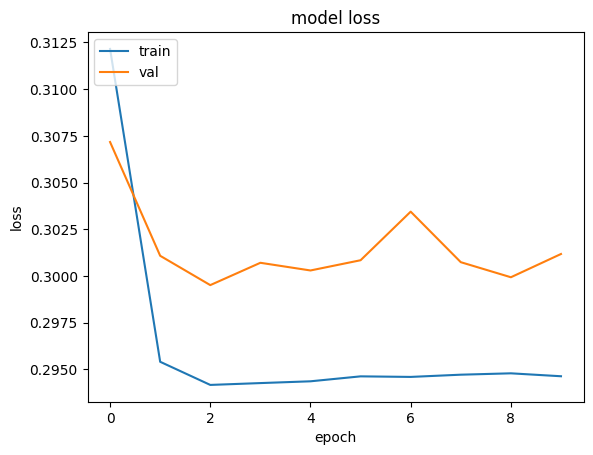

In [ ]:

import matplotlib.pyplot as plt

plt.plot(model_results.history['loss'])
plt.plot(model_results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

[seq2seq_eng-ger.h5](https://nextjournal.com/data/QmdLreGq3MREE65Agbw3WEYfxecJ8X5ED8ymBJY7FnRyVA?content-type=application/x-hdf&node-id=a11b7a60-0d2b-49a8-b9b4-05a9cfcecd46&filename=seq2seq_eng-ger.h5&node-kind=file)

# Testing the Machine Translation

Since we're impatient by nature, we'll simply use the pre-trained weights. Lets load them.

In [ ]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
model.load_weights('model.keras')

/home/ilja/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Ok, with the weights in place it's time to test our machine translation model by translating a few test sentences.

The inference mode works a bit differently than the training procedure. The procedure can be broken down into 4 steps:

1\. Encode the input sequence, return its internal states.

2\. Run the decoder using just the *start-of-sequence* character as input and the encoder internal states as the decoder's initial states.

3\. Append the character predicted (after lookup of the token) by the decoder to the decoded sequence.

4\. Repeat the process with the previously predicted character token as input and updates internal states.

![Inference Process.png](https://nextjournal.com/data/QmaQiZ99Jb3RFP2Mpp15YW1vVKDqsXiEFnDBDGULGc4q16?content-type=image/png&node-id=5138d692-bb12-438d-8b74-b0e7ad069b28&filename=Inference+Process.png&node-kind=file)

Let's go ahead and implement this. Since we only need the encoder for encoding the input sequence we'll split encoder and decoder into two separate models.

In [ ]:
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_outputs, state_h, state_c = decoder_lstm(
  decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)

decoder_model = Model(
  [decoder_inputs] + decoder_states_inputs,
  [decoder_outputs] + decoder_states)

In order to conveniently perform the lookup from step 3 above we'll create reverse-lookup dictionaries for both the input and target tokens.

In [ ]:
# reverse-lookup token index to turn sequences back to characters
reverse_input_char_index = dict(
  (i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict(
  (i, char) for char, i in target_token_index.items())

With that we can create a function to perform the whole process of decoding a given input sequence (inputs already tokenized).

In [ ]:
def decode_sequence(input_seq):
  # encode the input sequence to get the internal state vectors.
  states_value = encoder_model.predict(input_seq, verbose=0)
  
  # generate empty target sequence of length 1 with only the start character
  target_seq = np.zeros((1, 1, num_decoder_tokens))
  target_seq[0, 0, target_token_index['\t']] = 1.
  
  # output sequence loop
  stop_condition = False
  decoded_sentence = ''
  while not stop_condition:
    output_tokens, h, c = decoder_model.predict([target_seq] + states_value, verbose=0)
    
    # sample a token and add the corresponding character to the 
    # decoded sequence
    sampled_token_index = np.argmax(output_tokens[0, -1, :])
    sampled_char = reverse_target_char_index[sampled_token_index]
    decoded_sentence += sampled_char
    
    # check for the exit condition: either hitting max length
    # or predicting the 'stop' character
    if (sampled_char == '\n' or 
        len(decoded_sentence) > max_decoder_seq_length):
      stop_condition = True
      
    # update the target sequence (length 1).
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    target_seq[0, 0, sampled_token_index] = 1.
    
    # update states
    states_value = [h, c]
    
  return decoded_sentence

With that let's sample a few test cases! 

In [ ]:
for seq_index in range(10):
  input_seq = encoder_input_data[seq_index: seq_index + 1]
  decoded_sentence = decode_sequence(input_seq)
  print('-')
  print('Input sentence:', input_texts[seq_index])
  print('Decoded sentence:', decoded_sentence)

-
Input sentence: ﻿I have to go to sleep.
Decoded sentence: min       lllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllll
-
Input sentence: Most people think I'm crazy.
Decoded sentence: min       lllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllll
-
Input sentence: I love you.
Decoded sentence: min       lllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllll

Not bad for a model consisting only of two LSTM layers and a linear one! 

But those were all examples from the training set. Let's validate the model using our own example: Let's have the model translate something simple, like:

`"How are you?"`

We'll put all the tokenization and decoding into one cell and print out the decoded sequence.

In [ ]:
input_sentence = "How are you?"
test_sentence_tokenized = np.zeros(
  (1, max_encoder_seq_length, num_encoder_tokens), dtype='float32')
for t, char in enumerate(input_sentence):
  test_sentence_tokenized[0, t, input_token_index[char]] = 1.
print(input_sentence)
print(decode_sequence(test_sentence_tokenized))

How are you?
min       lllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllll


Great! But surely this simple model trained on 10k examples will have some failure cases! Let's try out some examples the model didn't see during training.

In [ ]:
val_input_texts = []
val_target_texts = []
line_ix = 12000
for line in lines[line_ix:line_ix+10]:
  input_text, target_text = line.split('\t')
  val_input_texts.append(input_text)
  val_target_texts.append(target_text)

val_encoder_input_data = np.zeros(
  (len(val_input_texts), max([len(txt) for txt in val_input_texts]),
   num_encoder_tokens), dtype='float32')

for i, input_text in enumerate(val_input_texts):
  for t, char in enumerate(input_text):
    val_encoder_input_data[i, t, input_token_index[char]] = 1.

In [ ]:
for seq_index in range(10):
  input_seq = val_encoder_input_data[seq_index: seq_index + 1]
  decoded_sentence = decode_sequence(input_seq)
  print('-')
  print('Input sentence:', val_input_texts[seq_index])
  print('Decoded sentence:', decoded_sentence[:-1])
  print('Ground Truth sentence:', val_target_texts[seq_index])

-
Input sentence: Tom is a senior.
Decoded sentence: min       llllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllll
Ground Truth sentence: jan Ton li jan pi sike suno mute.
-
Input sentence: I have no quarrel with Tom.
Decoded sentence: min       llllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllll
Ground Truth sentence: mi en jan Ton li jo ala e utala.
-
Input sentence: Just give it to me.
Decoded se

Ok, that clearly shows some failure cases. Note that for the evaluation texts we had input sequences longer than the longest sequence in the training set.

In [ ]:
max([len(txt) for txt in val_input_texts])

44

While the model is able to produce a decoded sequence for these inputs, it will produce worse outputs the longer the input sequences become. After all, the model was not trained to decode sequences that long. You can try this out by changing the `line_ix` parameter to something later in the dataset (maybe something around 50000).

# Summary and Outlook

This article showed the capabilities of encoder-decoder models combined with LSTM layers for sequence-to-sequence learning.

The dataset consisted of English-German sentence pairs. All characters of the respective sentences were first tokenized. The sequences of tokenized characters were then used as input and target for the encoder-decoder model.

During training we used the teacher forcing method where we offset the decoders input and target by one timestep. For inference, we used a slightly different setup, but still used the same modules we trained earlier. The input sequence was processed by the encoder and its final hidden states, along with the start-of-sequence character, were used as input for the decoder. Each predicted character was then fed back into the decoder while the hidden states were updated. We repeated this until the decoder predicted the end-of-sequence character telling us the predicted sequence is complete.

While this model is a rather simple and far away from state-of-the-art neural machine translation models it still shows some principles still used in more recent approaches (e.g. encoder-decoder models in the infamous [Attention Is All You Need](https://arxiv.org/abs/1706.03762) paper). Even [Google Translate](https://arxiv.org/abs/1609.08144) seems to be using a more sophisticated encoder-decoder model based on (bidirectional) LSTMs.

Going further, turning the LSTMs we used into their bidirectional version might  help improve the model. To become even better, one might want to turn to methods such as *self-attention* (described for example in a great [blogpost on distill.pub](https://distill.pub/2016/augmented-rnns/)) and embed them in the encoder-decoder structure.